In [1]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AdamWeightDecay
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json

2023-02-15 15:36:20.996643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:36:22.537192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-02-15 15:36:22.537341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-02-15 15:36:22.537352: W 

In [2]:
def QASCDataset(f, shuffle):
    input_format = "1"
    content, labels = [], []
    x = open(f).readlines()
    if shuffle:
        random.shuffle(x)
    for line in x:
        instance = json.loads(line)
        question = instance["question"]["stem"]
        choices = [item["text"] for item in instance["question"]["choices"]]
        if "answerKey" in instance:
            l = instance["answerKey"]
        else:
            l = "A"
        if input_format == "0":
            for c in choices:
                content.append("{} {}".format(question, c))
        elif input_format == "1":
            for c in choices:
                content.append("{} \\n {}".format(question, c))
        elif input_format == "2":
            for c in choices:
                content.append("{} {} {}".format(question, sep_token, c))
        answers = ["A", "B", "C", "D", "E", "F", "G", "H"]
        y = [0, 0, 0, 0, 0, 0, 0, 0]
        y[answers.index(l)] = 1
        labels += y
    return content, labels

In [3]:
df = pd.read_json('./data/qasc/train.jsonl', lines=True)
df

,id,question,answerKey,fact1,fact2,combinedfact,formatted_question
0,3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K,{'stem': 'What type of water formation is form...,F,beads of water are formed by water vapor conde...,Clouds are made of water vapor.,Beads of water can be formed by clouds.,What type of water formation is formed by clou...
1,3LS2AMNW5FPNJK3C3PZLZCPX562OQO,"{'stem': 'Where do beads of water come from?',...",E,beads of water are formed by water vapor conde...,Condensation is the change of water vapor to a...,Vapor turning into a liquid leaves behind bead...,Where do beads of water come from? (A) Too muc...
2,3TMFV4NEP8DPIPCI8H9VUFHJG8V8W3,"{'stem': 'What forms beads of water? ', 'choic...",B,beads of water are formed by water vapor conde...,An example of water vapor is steam.,Steam forms beads of water.,What forms beads of water? (A) Necklaces. (B)...
3,3KRVW3HTZNKBWXXDID9D28FTU7NSM9,{'stem': 'what kind of beads are formed from v...,C,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,h2o beads are formed by h2o vapor condensing,what kind of beads are formed from vapor conde...
4,3TE3O8573079OET7T6QOXPWZ0MHR2T,{'stem': 'what kind of beads are formed by the...,A,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,beads of h2o are formed by h2o vapor condensing,what kind of beads are formed by their vapor c...
...,...,...,...,...,...,...,...
8129,3KAKFY4PGU1LGXM77JAK2700NGCI3X,{'stem': 'Chitin can be used for protection by...,D,scales are used for protection by scaled animals,Fish scales are also composed of chitin.,Chitin can be used for protection by fish.,Chitin can be used for protection by whom? (A)...
8130,336YQZE83VDAQVZ26HW59X51JZ9M5M,{'stem': 'Which type of animal uses plates for...,B,scales are used for protection by scaled animals,Reptiles have scales or plates.,Reptiles use their plates for protection.,Which type of animal uses plates for protectio...
8131,3WZ36BJEV3FGS66VGOOUYX0LN8GTBU,{'stem': 'What are used for protection by fish...,A,scales are used for protection by scaled animals,Fish are backboned aquatic animals.,scales are used for protection by fish,What are used for protection by fish? (A) scal...
8132,3Z2R0DQ0JHDKFAO2706OYIXGNA4E28,"{'stem': 'What are pangolins covered in?', 'ch...",G,scales are used for protection by scaled animals,Pangolins have an elongate and tapering body c...,Pangolins are covered in overlapping protection.,What are pangolins covered in? (A) tunicates (...


In [4]:
train_data, train_label = QASCDataset('./data/qasc/train.jsonl', True)
test_data, test_label = QASCDataset('./data/qasc/test.jsonl', False)


In [5]:
flag = False
new_train_data = list()
new_train_label = list()

for i in range(len(train_label)):
    if train_label[i] == 0 and flag == True:
        new_train_data.append(train_data[i])
        new_train_label.append(train_label[i])
        flag = False
    elif train_label[i] == 1:
        new_train_data.append(train_data[i])
        new_train_label.append(train_label[i])
        flag = True

In [6]:
train_data = new_train_data
train_label = new_train_label

In [7]:
MDL_PATH = "microsoft/deberta-base"
MAX_LEN = 40
NUM_EPOCHS = 10
batch_size=8
LR = 1e-5
tokenizer = AutoTokenizer.from_pretrained(MDL_PATH)
deberta = TFAutoModelForSequenceClassification.from_pretrained(MDL_PATH)

2023-02-14 22:31:28.767734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 22:31:28.865891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 22:31:28.867663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 22:31:28.871073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
def tokenize(df):
    input_ids =  []
    attention_masks =  []
    for i, text in enumerate(df):
        tokens = tokenizer.encode_plus(text, max_length=MAX_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')          
        input_ids.append(np.asarray(tokens["input_ids"]).reshape(MAX_LEN,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(MAX_LEN,))
    return (np.asarray(input_ids), np.asarray(attention_masks))


def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [9]:
train_input_ids, train_attention_masks = tokenize(train_data)
y_train = indices_to_one_hot(train_label, 2)

In [10]:
input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_LEN,), name='attention_mask', dtype='int32')

x = deberta(input_ids, attention_mask=mask)[0]

x = tf.keras.layers.Dense(750, activation='relu', name='h1')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(150, activation='relu', name='h2')(x)

y = tf.keras.layers.Dense(1, name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_deberta_for_sequence_classi  TFSequenceClassifie  139193858  ['input_ids[0][0]',              
 fication (TFDebertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']  

In [11]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='percision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse", metrics=Metrics)

In [13]:
history = model.fit((train_input_ids, train_attention_masks), 
                    y_train,
                    batch_size = 100,
                    epochs=5)


Epoch 1/5
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2023-02-14 22:32:55.722835: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x299084e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 22:32:55.722944: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce 930MX, Compute Capability 5.0
2023-02-14 22:32:55.798857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-14 22:32:56.218397: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 22:32:56.369406: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


651/651 [==============================] - 2229s 3s/step - loss: 0.2086 - accuracy: 0.8647 - percision: 0.8647 - recall: 0.8647
Epoch 2/5
651/651 [==============================] - 2194s 3s/step - loss: 0.1275 - accuracy: 0.8750 - percision: 0.8750 - recall: 0.8750
Epoch 3/5
651/651 [==============================] - 2199s 3s/step - loss: 0.1103 - accuracy: 0.8750 - percision: 0.8750 - recall: 0.8750
Epoch 4/5
651/651 [==============================] - 2202s 3s/step - loss: 0.1095 - accuracy: 0.8750 - percision: 0.8750 - recall: 0.8750
Epoch 5/5
651/651 [==============================] - 2201s 3s/step - loss: 0.1095 - accuracy: 0.8750 - percision: 0.8750 - recall: 0.8750


In [14]:
# save model
model.save('./model/my_model_qasc.h5')

In [ ]:
from tensorflow.keras.models import load_model
from keras.utils import CustomObjectScope
import transformers


model = load_model('./model/my_model_qasc.h5' , custom_objects={"TFDebertaForSequenceClassification": transformers.TFDebertaForSequenceClassification})

In [16]:
test_input_ids, test_attention_masks = tokenize(test_data)
y_test = indices_to_one_hot(test_label, 2)


In [17]:
test_preds = model.predict((np.asarray(test_input_ids),
                            np.asarray(test_attention_masks)))

230/230 [==============================] - 172s 726ms/step


In [18]:
predictions = list()
for i in test_preds:
    predictions.append(np.argmax(i))
new_y_test = list()
for i in y_test:
    new_y_test.append(np.argmax(i))

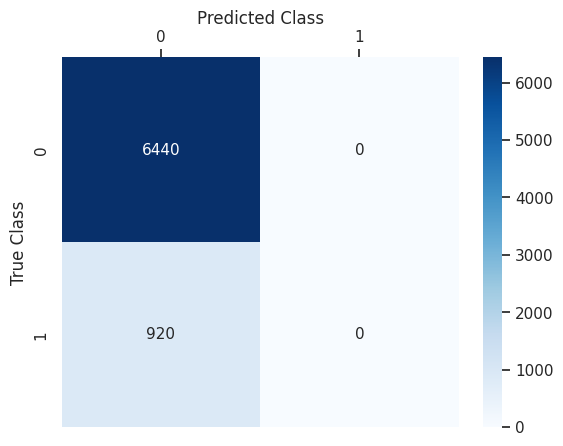

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      6440
           1       0.00      0.00      0.00       920

    accuracy                           0.88      7360
   macro avg       0.44      0.50      0.47      7360
weighted avg       0.77      0.88      0.82      7360



/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
confusion = confusion_matrix(new_y_test, predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = [0, 1]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')   
ax.set_ylabel('True Class')   
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(new_y_test, predictions, output_dict=False, target_names=["0", "1"],)
print(report)